## CIFAR100 Assignment

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [63]:
# Using the GPU if it exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [64]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100)

classes = train_dataset.classes


In [72]:
class CIFAR100Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CIFAR100Net()


In [73]:
def train(model, loader, optimizer, loss_fn, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1)%10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")

# Testing loop
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    print(f"Accuracy: {100 * correct / total:.2f}%")


In [74]:
print("\nTraining SequentialNet")
model = model.to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train(model, train_loader, opt, loss_fn)
test(model, test_loader)



Training SequentialNet
Epoch [10/100], Loss: 413.2687
Epoch [20/100], Loss: 93.2195
Epoch [30/100], Loss: 71.9172
Epoch [40/100], Loss: 65.0188
Epoch [50/100], Loss: 48.6625
Epoch [60/100], Loss: 40.2431
Epoch [70/100], Loss: 43.1147
Epoch [80/100], Loss: 38.9316
Epoch [90/100], Loss: 50.4115
Epoch [100/100], Loss: 40.6239
Accuracy: 37.68%


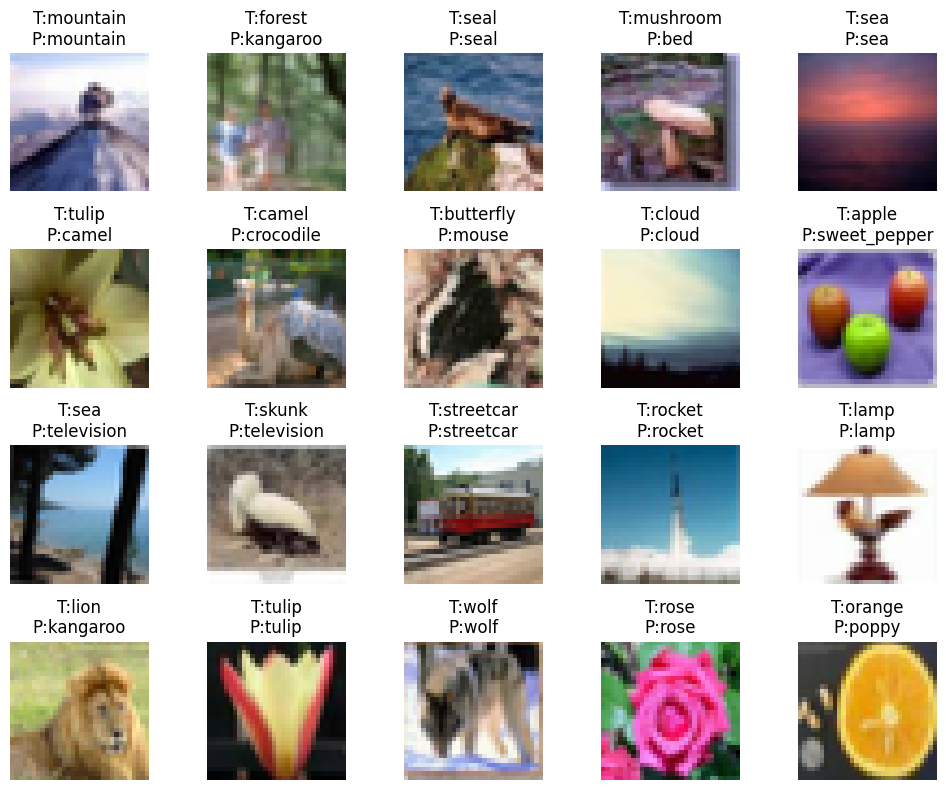

In [80]:
def visualize(model, loader, n=100, classes=None):
    model.eval()
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        preds = model(x).argmax(dim=1)
    rows = int(n ** 0.5)
    cols = int((n + rows - 1) / rows)
    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        img = x[i].cpu().permute(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        true_label = classes[y[i].item()] if classes else y[i].item()
        pred_label = classes[preds[i].item()] if classes else preds[i].item()
        plt.title(f"T:{true_label}\nP:{pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


visualize(model, test_loader, n=20, classes=classes)
